# Case study: Differential gene expression 	between cells with and without activation of the tumor suppressor p53

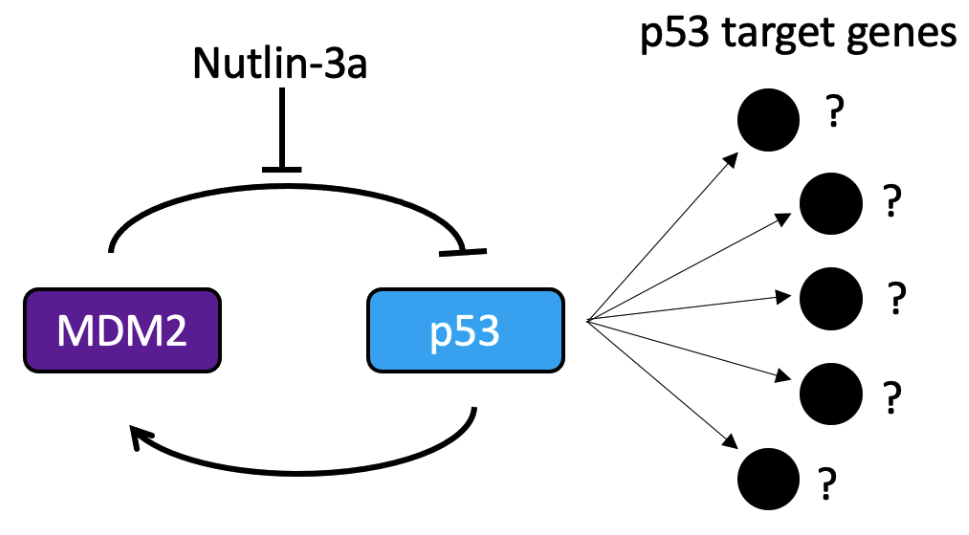

MCF-7 (breast cancer cell line) cells with and without Nutlin-3a stimilation.

**Research question:** Which genes are downstream of p53 (i.e. are upregulated by p53)?

Here we will use DESeq2 to perform differential gene expression analysis. DESeq2 has a nice tutorial that can be found [here](http://bioconductor.org/packages/devel/bioc/vignettes/DESeq2/inst/doc/DESeq2.html).

## Step 0. set up working directory

In [ ]:
USER <- Sys.getenv("USER")
setwd(paste0("/mnt/storage/",USER,"/jupyternotebooks/bulk_RNA_seq"))

## Step 1. Load data

The starting point of a DESeq2 analysis is a count matrix K with one row for each gene i and one column for each sample j. The matrix entries K ij indicate the number of sequencing reads that have been unambiguously mapped to a gene in a sample. Let's load the count matrix we generated in the previous notebook.

In [ ]:
cts <- as.matrix(read.csv("counts/mcf7_ns_s.counts.formatted", sep="\t", row.names = "Geneid"))

In [ ]:
head(cts, 5)

Next we will generate a dataframe containing metadata on our samples.

In [ ]:
coldata <- data.frame(
    row.names = c("MCF7_NS1", "MCF7_NS2", "MCF7_S1", "MCF7_S2"),
    condition = c("control", "control", "treatment", "treatment") # Specify wether the sample was treated with nutlin or not
)

In [ ]:
coldata

**It's critical that the columns of the count matrix and the rows of the coldata are in the same order**. This is the case here.

In [ ]:
all(rownames(coldata) == colnames(cts))

Next we construct the DESeqDataSet. For this we need:
- the count matrix (cts)
- the metadata (coldata)
- the design, this specifies which variables to use to perform differential gene expression testing. In our case this variable is stored in the "condition" column of the metadata dataframe, as we want to test for differential expression between treatment and control.

In [ ]:
suppressWarnings(library("DESeq2"))
dds <- DESeqDataSetFromMatrix(countData = cts,
                              colData = coldata,
                              design = ~ condition)
dds

Let's set the order of the treatment and control group. Our control group is the baseline, so we set this as the first level.

In [ ]:
dds$condition <- factor(dds$condition, levels = c("control","treatment"))

We will perform some prefiltering to only keep genes that have a count of at least 10 for a minimum of 2 samples

In [ ]:
smallestGroupSize <- 2
keep <- rowSums(counts(dds) >= 10) >= smallestGroupSize
dds <- dds[keep,]

## Step 2. Model read counts and performing differential expression analysis

Given the count matrix: $K_{ij}$ with one row for each gene $i$ and one columns for each sample $j$

Read counts $K_{ij}$ are modeled as a negative binomial distribution (a.k.a. gamma-Poisson distribution) with a fitted mean $\mu_{ij}$ and gene specific dispersion $\alpha_{i}$. 

<p style="text-align: center;">$K_{ij} \sim \text{NB}(\mu_{ij}, \alpha_{i})$</p>

For illustrative purposes, the distribution of the expression of genes in sample MCF7_NS1 is shown.

In [ ]:
hist(cts[, 'MCF7_NS1'], ylim=c(0, 200), col = "darkgray")

The fitted mean $\mu_{ij}$ is composed of sample-specific size factor $s_j$ and a parameter $q_{ij}$, proportional to the concentration of cDNA fragments from the gene $i$ in sample $j$.

<p style="text-align: center;">$\mu_{ij}=s_j \cdot q_{ij}$</p>

The parameter $s_j$, which is the same for all genes in a sample, accounts for differences in sequencing depths between two samples. It can also be advantageous to calculate a gene-specific normalization factor $s_{ij}$. This gene- and sample-specific normalization factor accounts for further sources of technical bias such as differing dependence on GC content, gene length, ...

In this case the formula looks like this:

<p style="text-align: center;">$\mu_{ij}=s_{ij} \cdot q_{ij}$</p>

Finally generalized linear models (GLMs) are used to fit for each gene as follows:

<p style="text-align: center;">$\log_2{q_{ij}} = \sum_r{x_{jr} \cdot \beta_{ir} }$</p>

With $x_{jr}$ a design matrix for $r$ conditions indicating wether sample $j$ belongs to each condition $r$ or not.

In this case we have only a single condition (control vs treatment) and thus the formula simplifies to:

<p style="text-align: center;">$\log_2{q_{ij}} = x_{j} \cdot \beta_{i} $</p>

$\beta_{i}$ gives the log2 fold change for gene $i$.

The variability between replicates is modeled using the dispersion parameter $\alpha_{i}$. It defines the relationship between the variance of the observed count and its mean value (how far do we expected the observed count will be from the mean value).

<p style="text-align: center;">$\text{Var}(K_{ij}) = E[(K_{ij} - \mu_{ij})^2] = \mu_{ij} + \alpha_i \cdot \mu_{ij}^2$
    
Accurate estimation of this dispersion parameter $\alpha_i$ is critical for statistical testing of differential expression. For studies with a small sample size this parameter is difficult to estimate. DESeq2 solves this issue by assuming that genes with similar average expression values will have a similar dispersion. 


In [ ]:
library(ggplot2)
data <- data.frame(
    mean = rowMeans(cts[rowSums(cts) != 0, ]),
    var  = rowVars(cts[rowSums(cts) != 0, ]))
ggplot(data, aes(x = mean, y = var)) +
    geom_point() +
    scale_x_continuous(trans = "log10") +
    scale_y_continuous(trans = "log10") +
    geom_abline(intercept = 0, slope = 1, color = "red", size = 2)

The Red line represents the case where the variance equals the mean

The **size factors** $s_{j}$ can be estimated for each sample using the function
    
        estimateSizeFactors

In [ ]:
dds <- estimateSizeFactors(dds)

In [ ]:
dds@colData

The **dispersion** $\alpha_{i}$ can be estimated using the function

    estimateDispersions

In [ ]:
dds <- estimateDispersions(dds)

In [ ]:
head(mcols(dds))

In [ ]:
ggplot(as.data.frame(mcols(dds)[!mcols(dds)$allZero, ])) +
    geom_point(aes(x = baseMean, y = baseVar )) + 
    geom_line(aes(x = baseMean, y = baseMean + dispFit * baseMean * baseMean ), color = "red", size = 2) +
    scale_x_continuous(trans = "log10") +
    scale_y_continuous(trans = "log10")

As you can see the red line now fits the data much better!

Finally we can **fit the GLM for each gene** to obtain $\beta_j$, the log2FC of each gene across the two conditions. using the function:

    nbinomWaldTest
    


In [ ]:
dds <- nbinomWaldTest(dds)

The results of this can be visualized using the function

    results

In [ ]:
res <- results(dds)
res

The three functions above:

    estimateSizeFactors
    estimateDispersions
    nbinomWaldTest
   
can be run in one go using the wrapper function:

    DESeq

In [ ]:
dds <- DESeq(dds)
res <- results(dds)
res

Genes with a low read count have a strong variance of the Log2FolcChange (see plot below). Because of this, weakly expressed genes can seem to have strong differences between two conditions. However, this is not due to a real difference but due to noise in the measurements. This will cause issues if we want to rank genes based on their log2fold change values.

In [ ]:
ggplot(as.data.frame(res), aes(x = baseMean, y = log2FoldChange)) +
    geom_point(aes(colour = padj < 0.01), size = 0.5) +
    scale_x_continuous(trans = "log10") +
    scale_color_manual(name = "padj < 0.01", values = setNames(c("red", "black"), c(T, F)))

As you can see genes with a low mean (left of the plot) have a big variance of the log2foldchange. This can also be seen by looking at the standard error of the log2foldchange vs the mean

In [ ]:
ggplot(as.data.frame(res), aes(x = baseMean, y = lfcSE)) +
    geom_point(size = 0.5) +
    scale_x_continuous(trans = "log10") +
    ylim(0, 3)

To account for this DESeq2 has a function to *shrink* Log2FoldChange towards zero in such a manner that the shrinkage is stronger when the available information for a gene is low (i.e. low number of counts, are dispersion is high).

The function for this is called

    lfcShrink

it takes the `dds` object as input together with the coefficient we want to shrink

In [ ]:
resultsNames(dds)

We want to shrink the coefficient `condition_treatment_vs_control` as this stores our Log2FoldChange values.

In [ ]:
resLFC <- lfcShrink(dds, coef="condition_treatment_vs_control")

In [ ]:
resLFC

In [ ]:
ggplot(as.data.frame(resLFC), aes(x = baseMean, y = log2FoldChange)) +
    geom_point(aes(colour = padj < 0.01), size = 0.5) +
    scale_x_continuous(trans = "log10") +
    scale_color_manual(name = "padj < 0.01", values = setNames(c("red", "black"), c(T, F)))

As you can see, now the effect of the mean on the variance of the Log2FoldChange is much smaller. Again we can also visualize this by plotting the standard error.

In [ ]:
ggplot(as.data.frame(resLFC), aes(x = baseMean, y = lfcSE)) +
    geom_point(size = 0.5) +
    scale_x_continuous(trans = "log10") +
    ylim(0, 3)

## Step 3. Downstream analysis

### Getting a list of up- or downregulated genes
To manipulate dataframe we use the package dplyr

In [ ]:
suppressWarnings(library(dplyr))

In [ ]:
resLFC_df <- as.data.frame(resLFC)

Let's define some thresholds

In [ ]:
log2FC_thr = 1
pad_thr = 0.01

In [ ]:
upregulated_genes <- row.names(resLFC_df %>% 
    filter(log2FoldChange > log2FC_thr, padj < pad_thr))

In [ ]:
downregulated_genes <- row.names(resLFC_df %>% 
    filter(log2FoldChange < log2FC_thr, padj < pad_thr))

## Sorting the gene list based on log2FC values

In [ ]:
resLFC_df %>%
    arrange(log2FoldChange)

### Plotting a heatmap

In [ ]:
library(pheatmap)

In [ ]:
pheatmap(cts[c(upregulated_genes, downregulated_genes), ], scale = "row", show_rownames = F)